Давайте попробуем поизучать сезонность торговых инстументов.
Возьмем, например, EURUSD
Экспортируем из метатрейдера дневной график, он там доступен с ноября 2002 года. 
В принципе, можно экспортировать любой ТФ, но для анализа сезонности нам должно быть достаточно дневных движений
Разметим колонки в файле, как DATE, TIME, OPEN, HIGH, LOW, CLOSE, VOLUME - именно в таком порядке данные расположены в файле выдачи экспорта истории метатрейдера.
Давайте зачитаем его в табличку:

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import glob
import os
import pandas as pd

file_pattern = 'Dukascopy-*.csv'
matching_files = glob.glob(file_pattern)

dfs = {}

for file_path in matching_files:
    df = pd.read_csv(file_path,
                 sep=',',
                 header=0,
                 dtype={
                     'Open': np.float64,
                     'High': np.float64,
                     'Low': np.float64,
                     'Close': np.float64},
                 encoding='utf-8',
                 parse_dates=['Date'],
                 date_format='%Y.%m.%d').set_index('Date')
    # Get the filename without extension
    filename = os.path.splitext(os.path.basename(file_path))[0]
    
    # Parse the second token
    second_token = filename.split('-')[1]

    dfs[second_token] = df
print(f'Loaded {len(dfs)} dataframes')

Loaded 34 dataframes


Найдем общий интервал дат (чтобы нас не отвлекали куски пустых графиков):

In [11]:
common_start = max(df.index.min() for df in dfs.values())
common_end = min(df.index.max() for df in dfs.values())
print(f'Common interval from {common_start} to {common_end}')

Common interval from 2011-09-19 00:00:00 to 2025-02-03 00:00:00


Обработаем данные: нам нужно только изменение от предыдущего закрытия до текущего:

In [12]:
dataframes = {}
for key, df in dfs.items():
    # Calculate the difference between consecutive CLOSE values
    df['MOVE'] = df['Close'].diff()
    # Handle the first row
    df.loc[df.index[0], 'MOVE'] = df.loc[df.index[0], 'Close'] - df.loc[df.index[0], 'Open']
    dataframes[key] = df.drop(columns=['Open', 'Close', 'High', 'Low'])

Теперь соберем их все в одну табличку:

In [17]:
common_dates = pd.bdate_range(start=common_start, end=common_end)
combined_df = pd.concat([df.reindex(common_dates) for df in dataframes.values()], axis=1, keys=dataframes.keys())
combined_df.columns = combined_df.columns.get_level_values(0)
combined_df.fillna(0.0, inplace=True)
combined_df.head(10)

,AUDCAD,AUDCHF,AUDJPY,AUDNZD,AUDUSD,BRENTCMDUSD,CADCHF,CADJPY,CHFJPY,EURAUD,...,NZDCHF,NZDJPY,NZDUSD,USA30IDXUSD,USA500IDXUSD,USATECHIDXUSD,USDCAD,USDCHF,USDJPY,XAUUSD
2011-09-19,-0.00060,-0.00560,-1.247,-0.01001,-0.01388,-2.808,-0.00479,-1.156,-0.841,0.00758,...,0.00211,-0.428,-0.00368,-105.66,-11.92,31.12,0.01266,0.00655,-0.192,-32.936
2011-09-20,0.00736,0.01040,0.269,0.00789,0.00547,1.191,0.00369,-0.314,-0.720,-0.00522,...,0.00364,-0.181,-0.00066,7.65,-2.00,-12.87,0.00200,0.00519,-0.137,24.789
2011-09-21,-0.00770,-0.00813,-1.802,0.00597,-0.02327,-1.362,-0.00131,-1.182,-1.166,0.01790,...,-0.01015,-1.736,-0.02296,-283.82,-35.33,-37.59,0.01552,0.01284,0.006,-21.476
2011-09-22,-0.01041,-0.01868,-2.491,-0.00455,-0.03018,-3.710,-0.00923,-1.709,-1.035,0.03057,...,-0.01239,-1.770,-0.02114,-450.84,-40.39,-86.86,0.02021,0.00860,-0.216,-41.951
2011-09-23,0.00361,0.00080,0.606,0.01138,0.00408,-1.329,-0.00351,0.326,0.625,-0.00282,...,-0.00626,-0.161,-0.00447,59.83,3.19,13.15,-0.00059,-0.00380,0.341,-83.814
2011-09-26,0.00250,0.00038,0.212,0.00104,0.00504,0.847,-0.00062,0.035,0.170,-0.00286,...,0.00051,0.230,0.00437,0.00,0.00,0.00,-0.00285,-0.00350,-0.222,-29.789
2011-09-27,0.00269,0.00191,1.066,-0.00357,0.00811,2.002,-0.00112,0.858,1.010,-0.00551,...,0.00320,1.011,0.00841,0.00,0.00,0.00,-0.00556,-0.00522,0.458,24.159
2011-09-28,0.00009,-0.00784,-1.221,0.00172,-0.01333,-3.517,-0.00718,-1.216,-0.604,0.01379,...,-0.00720,-1.086,-0.01205,0.00,0.00,0.00,0.01408,0.00410,-0.210,-41.584
2011-09-29,0.00267,-0.00298,0.223,0.00998,0.00007,1.607,-0.00567,0.031,0.535,0.00539,...,-0.00751,-0.241,-0.00534,0.00,0.00,0.00,0.00235,-0.00318,0.231,5.557
2011-09-30,0.00110,-0.00027,-0.726,0.00033,-0.01209,-2.663,-0.00095,-0.812,-0.854,-0.00480,...,-0.00019,-0.594,-0.00975,0.00,0.00,0.00,0.01453,0.01079,0.206,9.051


Стало гораздо приятнее, правда?
Нарисуем это добро на графичке:

Matplotlib is building the font cache; this may take a moment.


<Axes: >

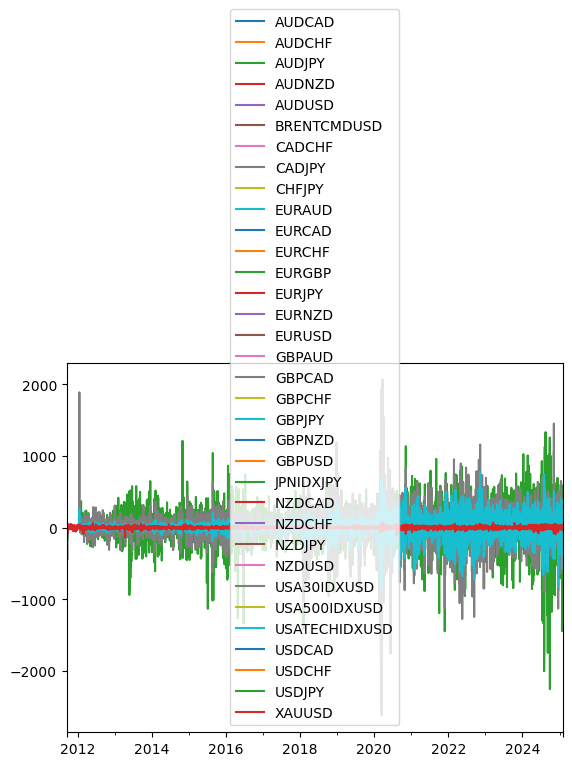

In [18]:
import matplotlib
combined_df.plot()

In [22]:
import scipy

corr_matrix = combined_df.corr().dropna(how='all').dropna(axis=1, how='all')
corr_matrix.head(50)

,AUDCAD,AUDCHF,AUDJPY,AUDNZD,AUDUSD,BRENTCMDUSD,CADCHF,CADJPY,CHFJPY,EURAUD,...,NZDCHF,NZDJPY,NZDUSD,USA30IDXUSD,USA500IDXUSD,USATECHIDXUSD,USDCAD,USDCHF,USDJPY,XAUUSD
AUDCAD,1.000000,0.447092,0.433767,0.269441,0.689844,-0.023559,-0.234736,-0.212974,0.008017,-0.539186,...,0.291946,0.293640,0.510210,0.133285,0.156384,0.161537,0.039312,-0.218977,-0.223451,0.247912
AUDCHF,0.447092,1.000000,0.571694,0.283418,0.568031,0.171999,0.756260,0.315190,-0.396631,-0.706564,...,0.839844,0.430534,0.384431,0.321175,0.324644,0.254186,-0.343515,0.522732,0.098502,0.057057
AUDJPY,0.433767,0.571694,1.000000,0.285852,0.650496,0.225148,0.314317,0.781695,0.497918,-0.587936,...,0.412953,0.854317,0.461947,0.447871,0.451158,0.353971,-0.468492,-0.019229,0.533013,0.060179
AUDNZD,0.269441,0.283418,0.285852,1.000000,0.241338,0.084838,0.114776,0.127407,0.026363,-0.307939,...,-0.265751,-0.237644,-0.344382,0.114625,0.107079,0.083486,-0.073146,0.069126,0.096418,-0.007286
AUDUSD,0.689844,0.568031,0.650496,0.241338,1.000000,0.201026,0.114489,0.225116,0.119332,-0.649324,...,0.427249,0.523277,0.818762,0.355010,0.370473,0.304611,-0.665314,-0.391252,-0.259068,0.384460
BRENTCMDUSD,-0.023559,0.171999,0.225148,0.084838,0.201026,1.000000,0.209022,0.260859,0.063290,-0.206776,...,0.128553,0.182352,0.149180,0.220851,0.201043,0.110083,-0.330671,-0.015105,0.051080,0.145056
CADCHF,-0.234736,0.756260,0.314317,0.114776,0.114489,0.209022,1.000000,0.505219,-0.430106,-0.381070,...,0.700901,0.265275,0.049649,0.268724,0.257269,0.177167,-0.408336,0.725126,0.271139,-0.116134
CADJPY,-0.212974,0.315190,0.781695,0.127407,0.225116,0.260859,0.505219,1.000000,0.538341,-0.264504,...,0.249894,0.723355,0.144386,0.399061,0.382634,0.272074,-0.525917,0.139731,0.747178,-0.112297
CHFJPY,0.008017,-0.396631,0.497918,0.026363,0.119332,0.063290,-0.430106,0.538341,1.000000,0.081873,...,-0.414356,0.488507,0.098645,0.152334,0.147282,0.109284,-0.146059,-0.558393,0.511098,-0.012221
EURAUD,-0.539186,-0.706564,-0.587936,-0.307939,-0.649324,-0.206776,-0.381070,-0.264504,0.081873,1.000000,...,-0.529733,-0.435083,-0.453068,-0.349406,-0.351138,-0.280628,0.388647,-0.121009,-0.017241,-0.141441


In [ ]:
Ну и давайте найдем наиболее и наименее скоррелированные инструменты:

In [25]:
df_corr = corr_matrix.unstack().reset_index()
df_corr.columns = ['Instrument 1', 'Instrument 2', 'Correlation']
df_corr = df_corr[df_corr['Instrument 1'] < df_corr['Instrument 2']]

10 самых высоко коррелированных инструментов:

In [26]:
df_corr = df_corr.sort_values('Correlation', ascending=False)
df_corr.head(10)

,Instrument 1,Instrument 2,Correlation
946,USA30IDXUSD,USA500IDXUSD,0.913620
981,USA500IDXUSD,USATECHIDXUSD,0.908337
93,AUDJPY,NZDJPY,0.854317
58,AUDCHF,NZDCHF,0.839844
162,AUDUSD,NZDUSD,0.818762
75,AUDJPY,CADJPY,0.781695
564,GBPAUD,GBPNZD,0.772209
320,EURAUD,EURNZD,0.762474
40,AUDCHF,CADCHF,0.756260
461,EURJPY,GBPJPY,0.750939


Ну и, соответственно, 10 инструментов максимально анти-коррелированных:

In [27]:
df_corr = df_corr.sort_values('Correlation', ascending=True)
df_corr.head(10)

,Instrument 1,Instrument 2,Correlation
43,AUDCHF,EURAUD,-0.706564
500,EURNZD,NZDCHF,-0.703067
502,EURNZD,NZDUSD,-0.677006
166,AUDUSD,USDCAD,-0.665314
214,CADCHF,EURCAD,-0.655056
145,AUDUSD,EURAUD,-0.649324
541,EURUSD,USDCHF,-0.647933
426,EURGBP,GBPCHF,-0.642125
706,GBPNZD,NZDUSD,-0.609952
914,NZDUSD,USDCAD,-0.608159
